# Convolutional Layers

## Preparations

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import image

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=5, suppress=True)


## Single Image Convolution

A convolution is done by multiplying a pixel’s and its neighboring pixels color value by a matrix (kernel matrix).

Here, we implement a convolution function for a single image. The implemenation is as follows, where:
* `img_in` is the image as a 2D matrix
* `kernel` is the filter kernel matrix
* `S` is the stride number

In [2]:
def convolve(img_in, kernel, S):
    F, _ = kernel.shape
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (F - S), S)
    C = np.arange(0, nc - (F - S), S)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] = np.sum(kernel * img_in[r:r+F, c:c+F])

    return img_out

Typically, when `s=1`, the dimension should not change. This is possible if the image has been previously padded. For a `3x3` filter matrix, we need 1 layer of padding. For a `5x5` filter matrix, we will need two layes of padding. However, if the filter dimensions are even numbers, we will not be able to apply uniform padding. Check [this material](https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html) for more infomation.

## Single Image Pooling

Pooling is a downsampling technique used in convolutional neural networks (CNNs) to reduce spatial dimensions of feature maps while preserving important features. It achieves this by selecting the maximum/mean value within each small, overlapping region (or "window") of the feature map. 

In [3]:
def maxpool(img_in, F, S):
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (F - S), S)
    C = np.arange(0, nc - (F - S), S)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] = np.max(img_in[r:r+F, c:c+F])

    return img_out

In [4]:
def meanpool(img_in, F, S):
    nr, nc, = img_in.shape

    R = np.arange(0, nr - (F - S), S)
    C = np.arange(0, nc - (F - S), S)
    
    img_out = np.zeros([len(R), len(C)])

    for i, r in enumerate(R):
        for j, c in enumerate(C):
            img_out[i, j] = np.mean(img_in[r:r+F, c:c+F])

    return img_out

## Single Image Normalization

This is a simple min-max normalization. This process causes the pixel values to range from 0 to 1.

In [5]:
def normalize(img_in):
    min_val = np.min(img_in)
    max_val = np.max(img_in)
    return (img_in - min_val) / (max_val - min_val)

## Batch Convolution

Batch convolution involves:
* `D` images with a dimension of `W x H`
* `K` filters with a kernel spatial dimension of `F x F` 
* `S` (stride number)
* `P` (padding layer number)

In [6]:
def batch_convolve(input3d, filter3d, P, S=1):
    # Volumetric matrix is addressed by using 3 indices: [first index, second index, third index]
    # Depth is represented first index
    D, H, W = input3d.shape;
    K, F, _ = filter3d.shape;
    
    # Do ZERO padding
    input3d = np.pad(input3d, ((0, 0), (P, P), (P, P)), 'constant', constant_values=((0, 0), (0, 0), (0, 0)))

    W2 = np.int32((W - F + 2 * P) / S + 1)
    H2 = np.int32((H - F + 2 * P) / S + 1)
    D2 = np.int32(K) 
   
    output3d = np.zeros((D2, W2, H2), dtype=np.float32)

    for d in range(D):
        input = input3d[d, :, :]
        for d2 in range(D2):
            output3d[d2, :, :] = output3d[d2, :, :] + convolve(input, kernel=filter3d[d2, :, :], S=S)

    return output3d

## Batch Pooling

Batch pooling involves:
* `D` images with a dimension of `W x H`
* `F` (spatial dimension)
* `S` (stride number)

In [7]:
def batch_maxpool(input3d, F, S):
    D, H, W = input3d.shape;

    W2 = np.int32((W - F) / S + 1)
    H2 = np.int32((H - F) / S + 1)
    D2 = np.int32(D)

    output3d = np.zeros((D2, W2, H2), dtype=np.float32)

    for d2 in range(D2):
        input = input3d[d2, :, :]
        output3d[d2, :, :] = maxpool(input, F, S)

    return output3d

In [8]:
def batch_meanpool(input3d, F, S):
    D, H, W = input3d.shape;

    W2 = np.int32((W - F) / S + 1)
    H2 = np.int32((H - F) / S + 1)
    D2 = np.int32(D)

    output3d = np.zeros((D2, W2, H2), dtype=np.float32)

    for d2 in range(D2):
        input = input3d[d2, :, :]
        output3d[d2, :, :] = meanpool(input, F, S)

    return output3d

## Batch Normalization

In [9]:
def batch_normalization(input3d):
    D, H, W = input3d.shape;
    output3d = np.zeros((D, W, H), dtype=np.float32)

    for d in range(D):
        output3d[d, :, :] = normalize(input3d[d, :, :])

    return output3d

----

## Demonstrations

For the demonstration, we will load a colored image (3 channels). We will first need to re-arrange the image matrix such that it is in the desired format, which is: `[Depth x Width x Height]`.

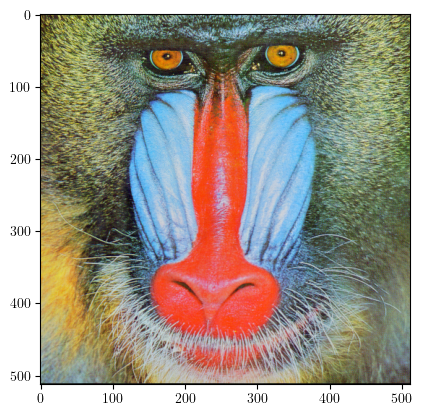

In [10]:
%matplotlib inline

baboon = image.imread('./baboon.png')
plt.imshow(baboon)
plt.show()

Convert to `[Depth x Width x Height]` and show the images separately.

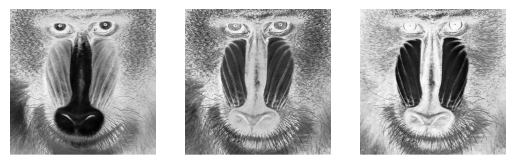

In [11]:
%matplotlib inline

baboon = np.array( [baboon[:, :, 0],
                    baboon[:, :, 1],
                    baboon[:, :, 2]], dtype=np.float32)

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(baboon[i,:,:], cmap='Greys')
    plt.axis('off')

Let's apply 3 arbitrary filters.

In [12]:
F = np.array([[[-2, -1,  0],
               [-1,  1,  1],
               [ 0,  1,  2]],
              [[ 1,  0,  1],
               [ 2,  0, -2],
               [ 1,  0, -1]],
              [[0.0625, 0.125, 0.0625],
               [0.125, 0.25, 0.125],
               [0.0625, 0.125, 0.0625]],
             ], dtype=np.float32)

output = batch_convolve(baboon, F, 1)
output = batch_meanpool(output, 2, 2)
output = batch_normalization(output)


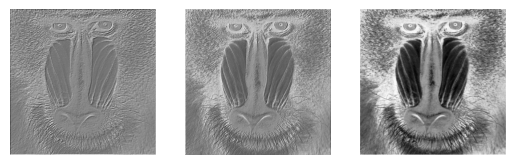

In [13]:
for i in range(3):
    plt.subplot(1, 3, i+1)
    # Rescale the weights to be between 0 and 255
    plt.imshow(output[i,:,:]*255, cmap='Greys')
    plt.axis('off')

In [14]:
print("Shape of the input image")
print(baboon.shape)

print("Shape of the output image")
print(output.shape)

Shape of the input image
(3, 512, 512)
Shape of the output image
(3, 256, 256)
